In [1]:
import numpy as np
import h5py
from tqdm import tqdm
import random
import pandas as pd
import itertools as it
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

from utils import peaking_detection
from meta_feature import dataset_ids_CC18, anchor_list_denser, feature_num_CC18_remove_redundancy, feature_num_CC18, class_num_CC18, learner_zoo

In [2]:
file_paths = [  '../dataset/LCDB11_ER_CC18_noFS_raw.hdf5',
                '../dataset/LCDB11_ER_CC18_minmaxFS_raw.hdf5',
                '../dataset/LCDB11_ER_CC18_standardFS_raw.hdf5']
dataset_nofs, dataset_minmaxfs, dataset_standardfs = [h5py.File(fp, 'r')['error_rate'][...] for fp in file_paths]


In [3]:
conv_matrix_nofs, conv_h_matrix_nofs, conv_i_matrix_nofs, conv_j_matrix_nofs = peaking_detection(dataset_nofs, flat_filter = False, bonferroni = True)
conv_matrix_minmaxfs, conv_h_matrix_minmaxfs, conv_i_matrix_minmaxfs, conv_j_matrix_minmaxfs = peaking_detection(dataset_minmaxfs, flat_filter = False, bonferroni = True)
conv_matrix_standardfs, conv_h_matrix_standardfs, conv_i_matrix_standardfs, conv_j_matrix_standardfs = peaking_detection(dataset_standardfs, flat_filter = False, bonferroni = True)

  0%|          | 0/72 [00:00<?, ?it/s]c:\Users\cyan1\code\lcdb1.1\analysis\utils.py:659: RuntimeWarning: Mean of empty slice
  mean_curve = np.nanmean(curves_group, axis=0)
  3%|▎         | 2/72 [00:02<01:50,  1.58s/it]C:\Users\cyan1\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
100%|██████████| 72/72 [01:15<00:00,  1.05s/it]


### Heatmap and Bar chart

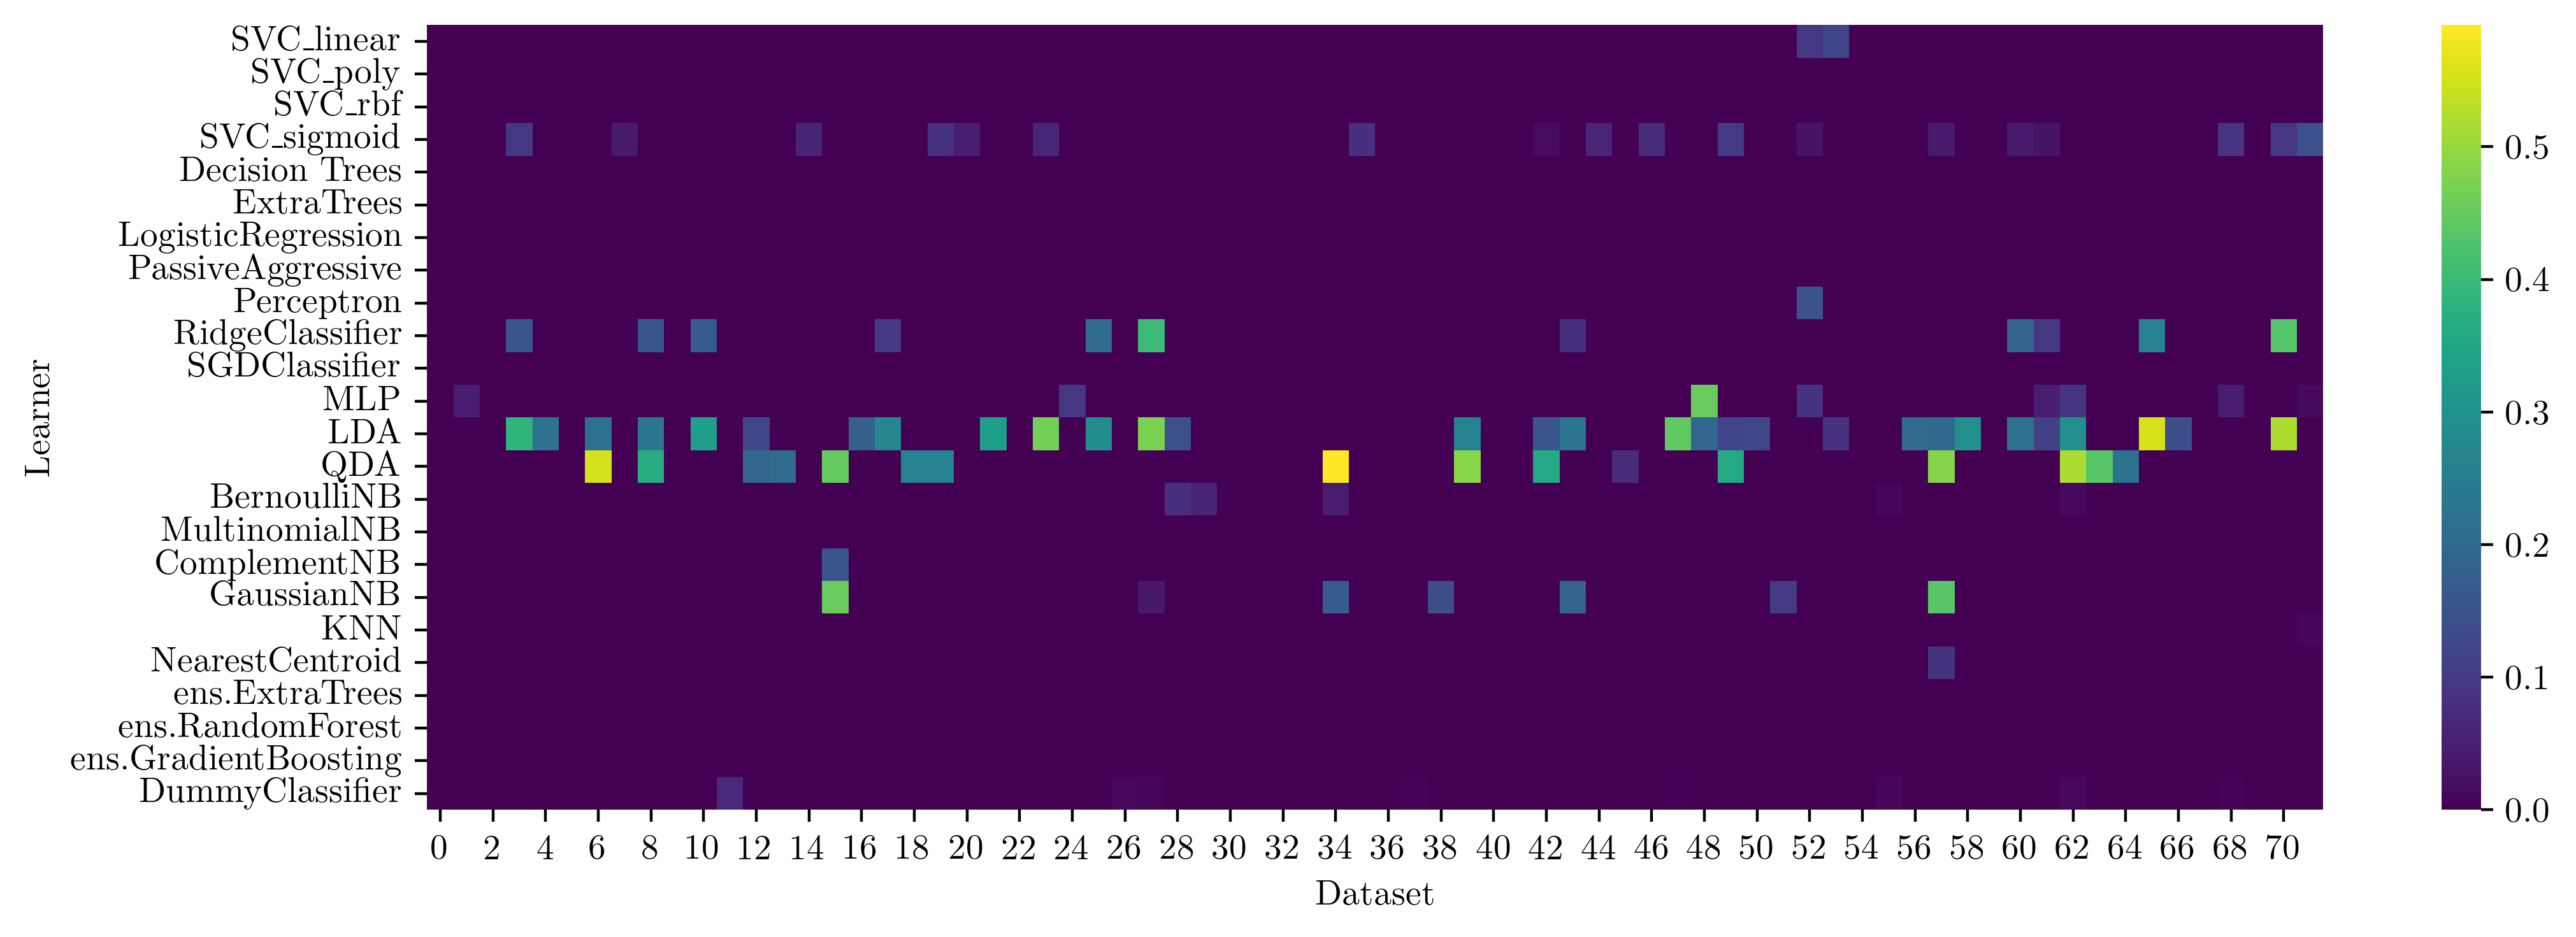

In [4]:
plt.figure(figsize=(12, 4), dpi=400)
ax = sns.heatmap(conv_matrix_nofs, cmap="viridis", annot=False, cbar=True)
yticks = range(len(learner_zoo))
ax.set_yticks([y + 0.5 for y in yticks])    # y tick align
ax.set_yticklabels(learner_zoo, rotation=0)
plt.xlabel('Dataset')
plt.ylabel('Learner')
plt.show()

In [5]:
percentages_nofs = (np.sum(conv_matrix_nofs > 0, axis=1) / conv_matrix_nofs.shape[1]) * 100
percentages_minmaxfs = (np.sum(conv_matrix_minmaxfs > 0, axis=1) / conv_matrix_minmaxfs.shape[1]) * 100
percentages_standardfs = (np.sum(conv_matrix_standardfs > 0, axis=1) / conv_matrix_standardfs.shape[1]) * 100


# filter some learner
exclude_indices = [13, 14, 15, 16, 17, 18, 23]      # list(range(14, 18))  no Naive Bayes  13 QDA  23 DUMMY
learner_zoo_filtered = [learner for i, learner in enumerate(learner_zoo) if i not in exclude_indices]
percentages_nofs = [val for i, val in enumerate(percentages_nofs) if i not in exclude_indices]
percentages_minmaxfs = [val for i, val in enumerate(percentages_minmaxfs) if i not in exclude_indices]
percentages_standardfs = [val for i, val in enumerate(percentages_standardfs) if i not in exclude_indices]

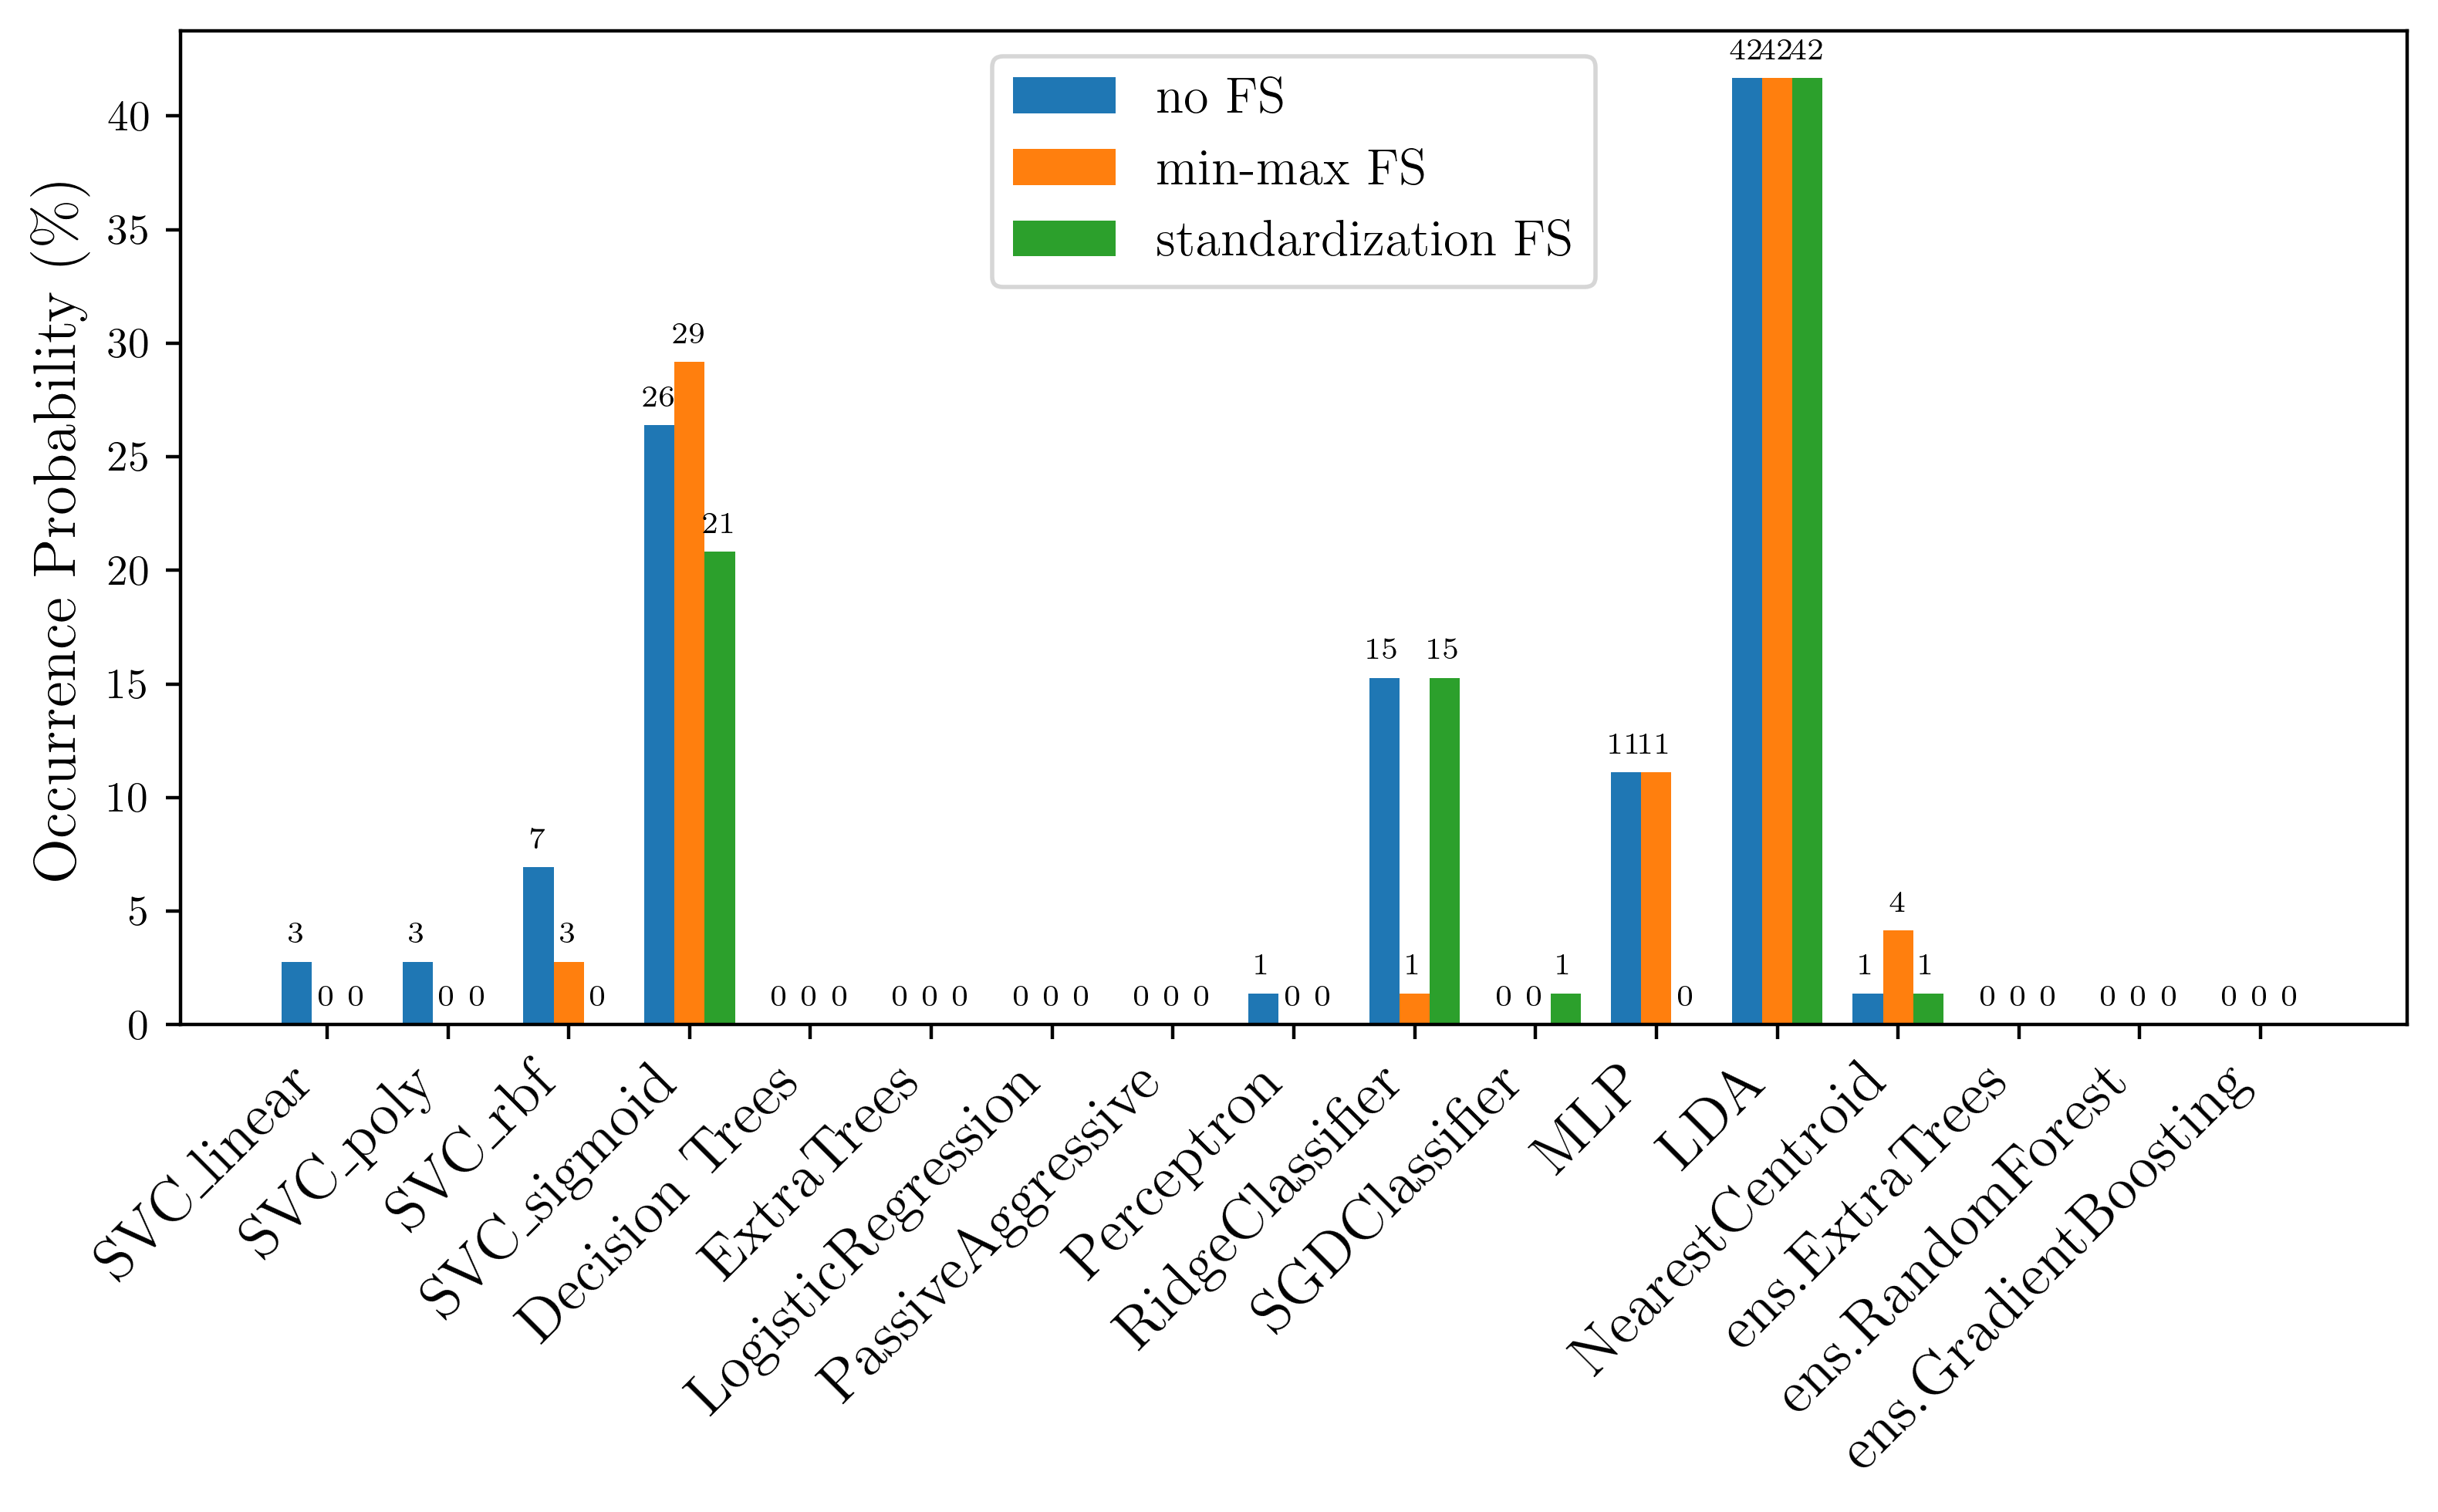

In [6]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=400)

width = 0.25
x = np.arange(len(learner_zoo_filtered))  

bar1 = ax.bar(x - width,    percentages_nofs,       width, label='no FS')
bar2 = ax.bar(x ,           percentages_minmaxfs,   width, label='min-max FS')
bar3 = ax.bar(x + width,    percentages_standardfs, width, label='standardization FS')

ax.set_ylabel(r'Occurrence Probability (\%)', fontsize = 14)
ax.set_xticks(x)
ax.set_xticklabels(learner_zoo_filtered, rotation=45, ha='right', fontsize = 14)  
ax.legend(loc = 'upper center',fontsize = 12)

# percentage
def autolabel(bars):
    for rect in bars:
        height = rect.get_height()
        # if height > 0:  # only annotate bars with a height greater than 0
        ax.annotate(f'{height:.0f}',    # integer
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", ha='center', va='bottom', 
                    fontsize = 7)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
plt.show()


### position of peak

##### MLP

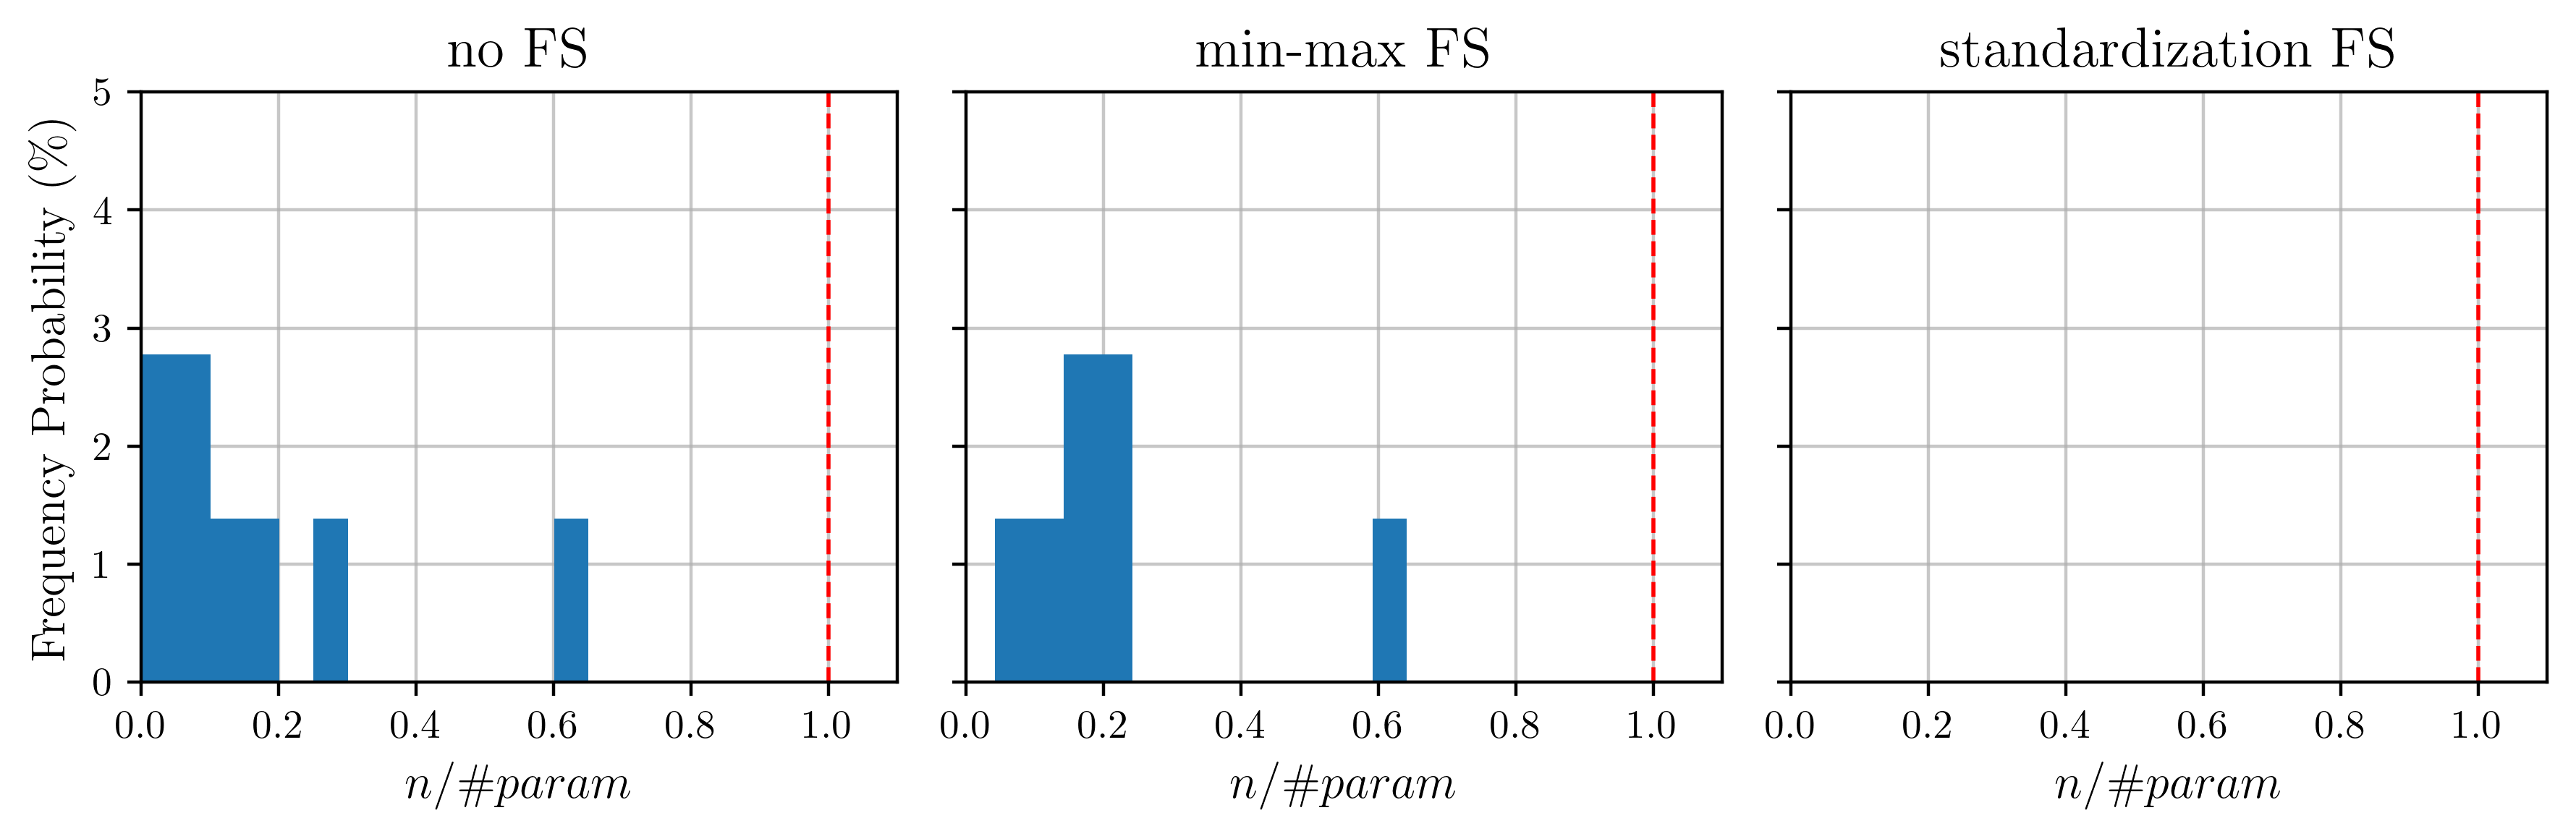

In [8]:
LEARNER = 11
bin_width = 0.05 

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (matrix, dataset, ax, title) in enumerate(zip(
    [conv_i_matrix_nofs, conv_i_matrix_minmaxfs, conv_i_matrix_standardfs], 
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):
    # store ratios for histogram plotting
    ratios = []  
    for data_idx in range(conv_i_matrix_nofs.shape[1]):
        if np.isnan(matrix[LEARNER, data_idx]):  # filter out no violation case
            continue

        peak_position = matrix[LEARNER, data_idx]
        ideal_peak = (feature_num_CC18[data_idx] + 1) * 100 + class_num_CC18[data_idx] * (100 + 1)
        ratio = peak_position / ideal_peak
        ratios.append(ratio)
    if len(ratios) > 0:
        bins = np.arange(min(ratios), max(ratios) + bin_width, bin_width)
        n, bins, _ = ax.hist(ratios, bins=bins, density=False)
        n = (n / conv_i_matrix_nofs.shape[1]) * 100 # convert into %
        ax.cla()  
        ax.bar(bins[:-1], n, width=bin_width, align='edge')
    ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('$n/\\#param$', fontsize=12)
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 5)
    ax.set_title(title, fontsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # grid bottom
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.7)
axes[0].set_ylabel(r'Frequency Probability (\%)', fontsize=12)

plt.tight_layout()
plt.show()

##### LDA

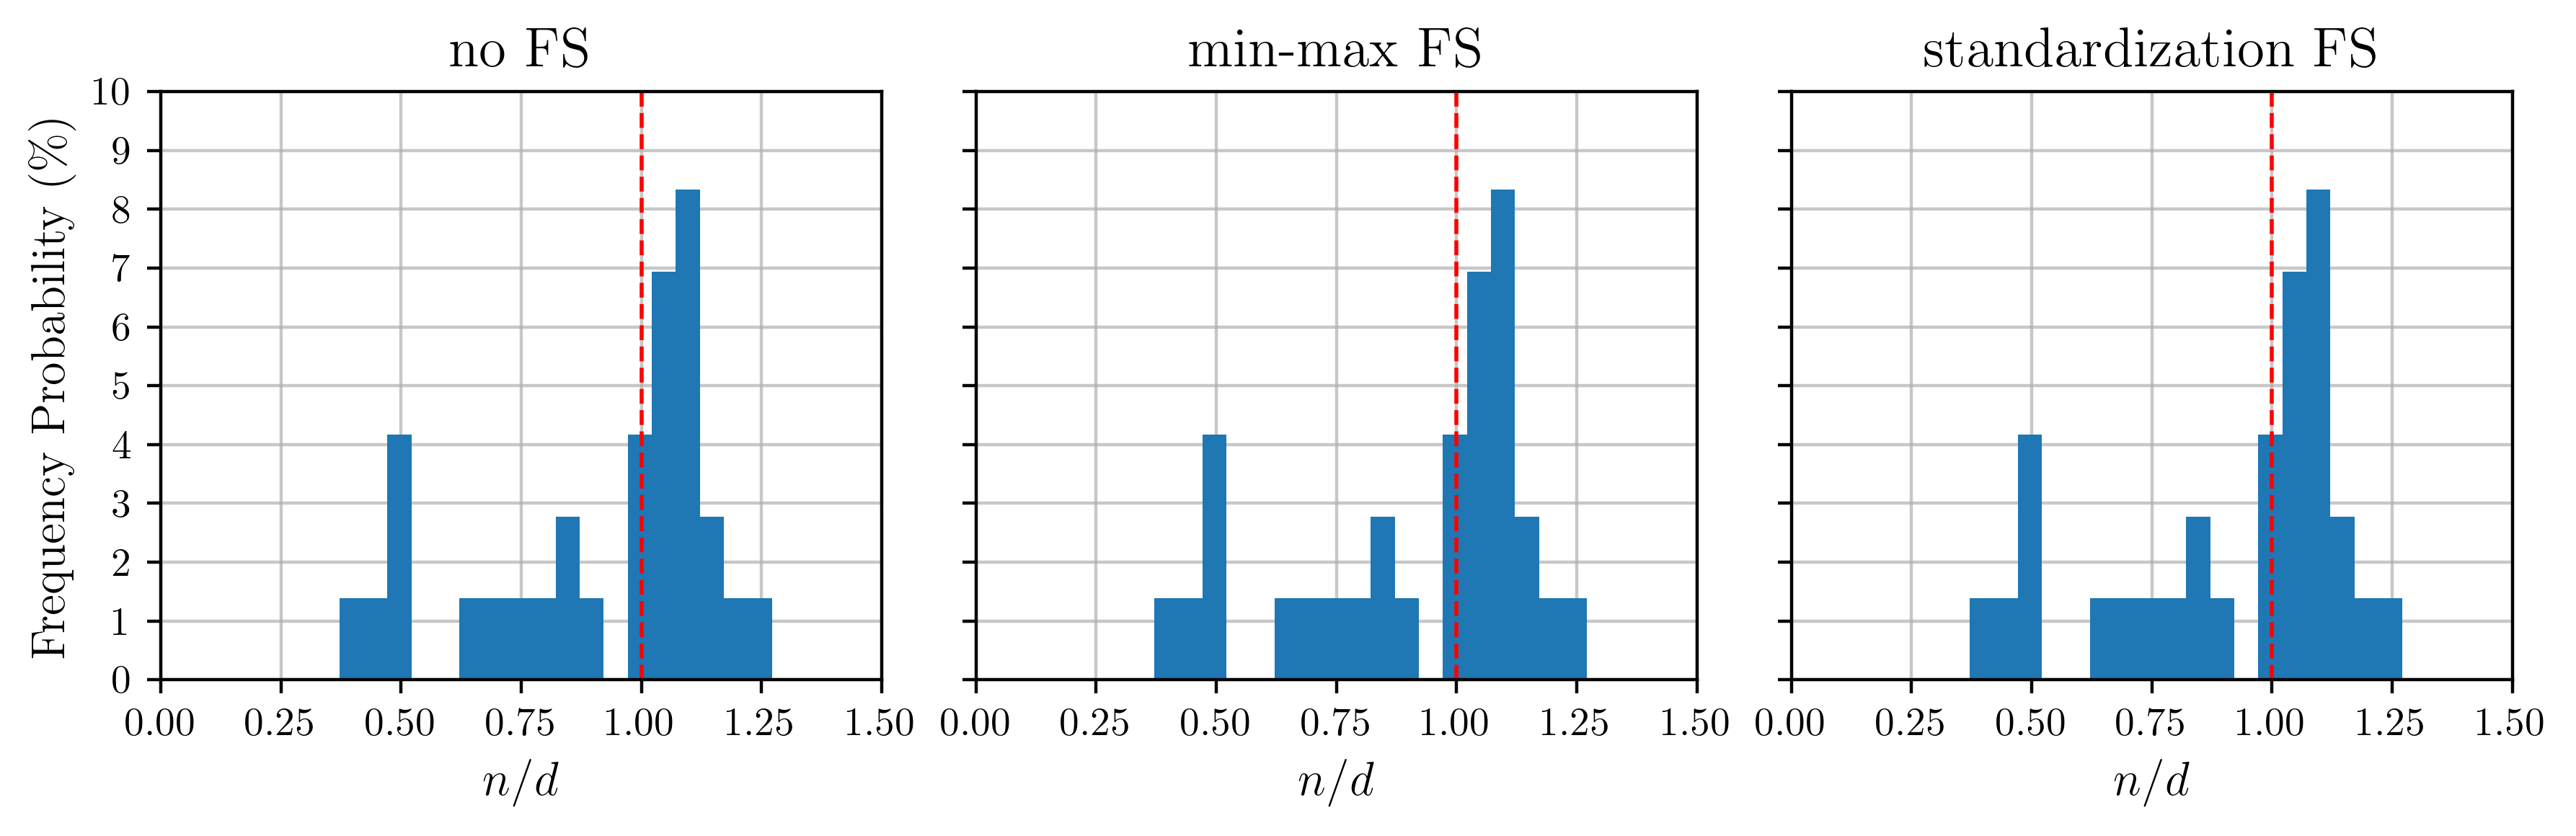

In [9]:
LEARNER = 12
bin_width = 0.05 

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (matrix, dataset, ax, title) in enumerate(zip(
    [conv_i_matrix_nofs, conv_i_matrix_minmaxfs, conv_i_matrix_standardfs], 
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):
    # store ratios for histogram plotting
    ratios = []  
    for data_idx in range(conv_i_matrix_nofs.shape[1]):
        if np.isnan(matrix[LEARNER, data_idx]):  # filter out no violation case
            continue

        peak_position = matrix[LEARNER, data_idx]
        ideal_peak = feature_num_CC18[data_idx]
        ratio = peak_position / ideal_peak
        ratios.append(ratio)
    if len(ratios) > 0:
        bins = np.arange(min(ratios), max(ratios) + bin_width, bin_width)
        n, bins, _ = ax.hist(ratios, bins=bins, density=False)
        n = (n / conv_i_matrix_nofs.shape[1]) * 100 # convert into %
        ax.cla()  
        ax.bar(bins[:-1], n, width=bin_width, align='edge')
    ax.axvline(x=1, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('$n/d$', fontsize=12)
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 10)
    ax.set_title(title, fontsize=14)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # grid bottom
    ax.set_axisbelow(True)
    ax.grid(True, alpha=0.7)
axes[0].set_ylabel(r'Frequency Probability (\%)', fontsize=12)

plt.tight_layout()
plt.show()

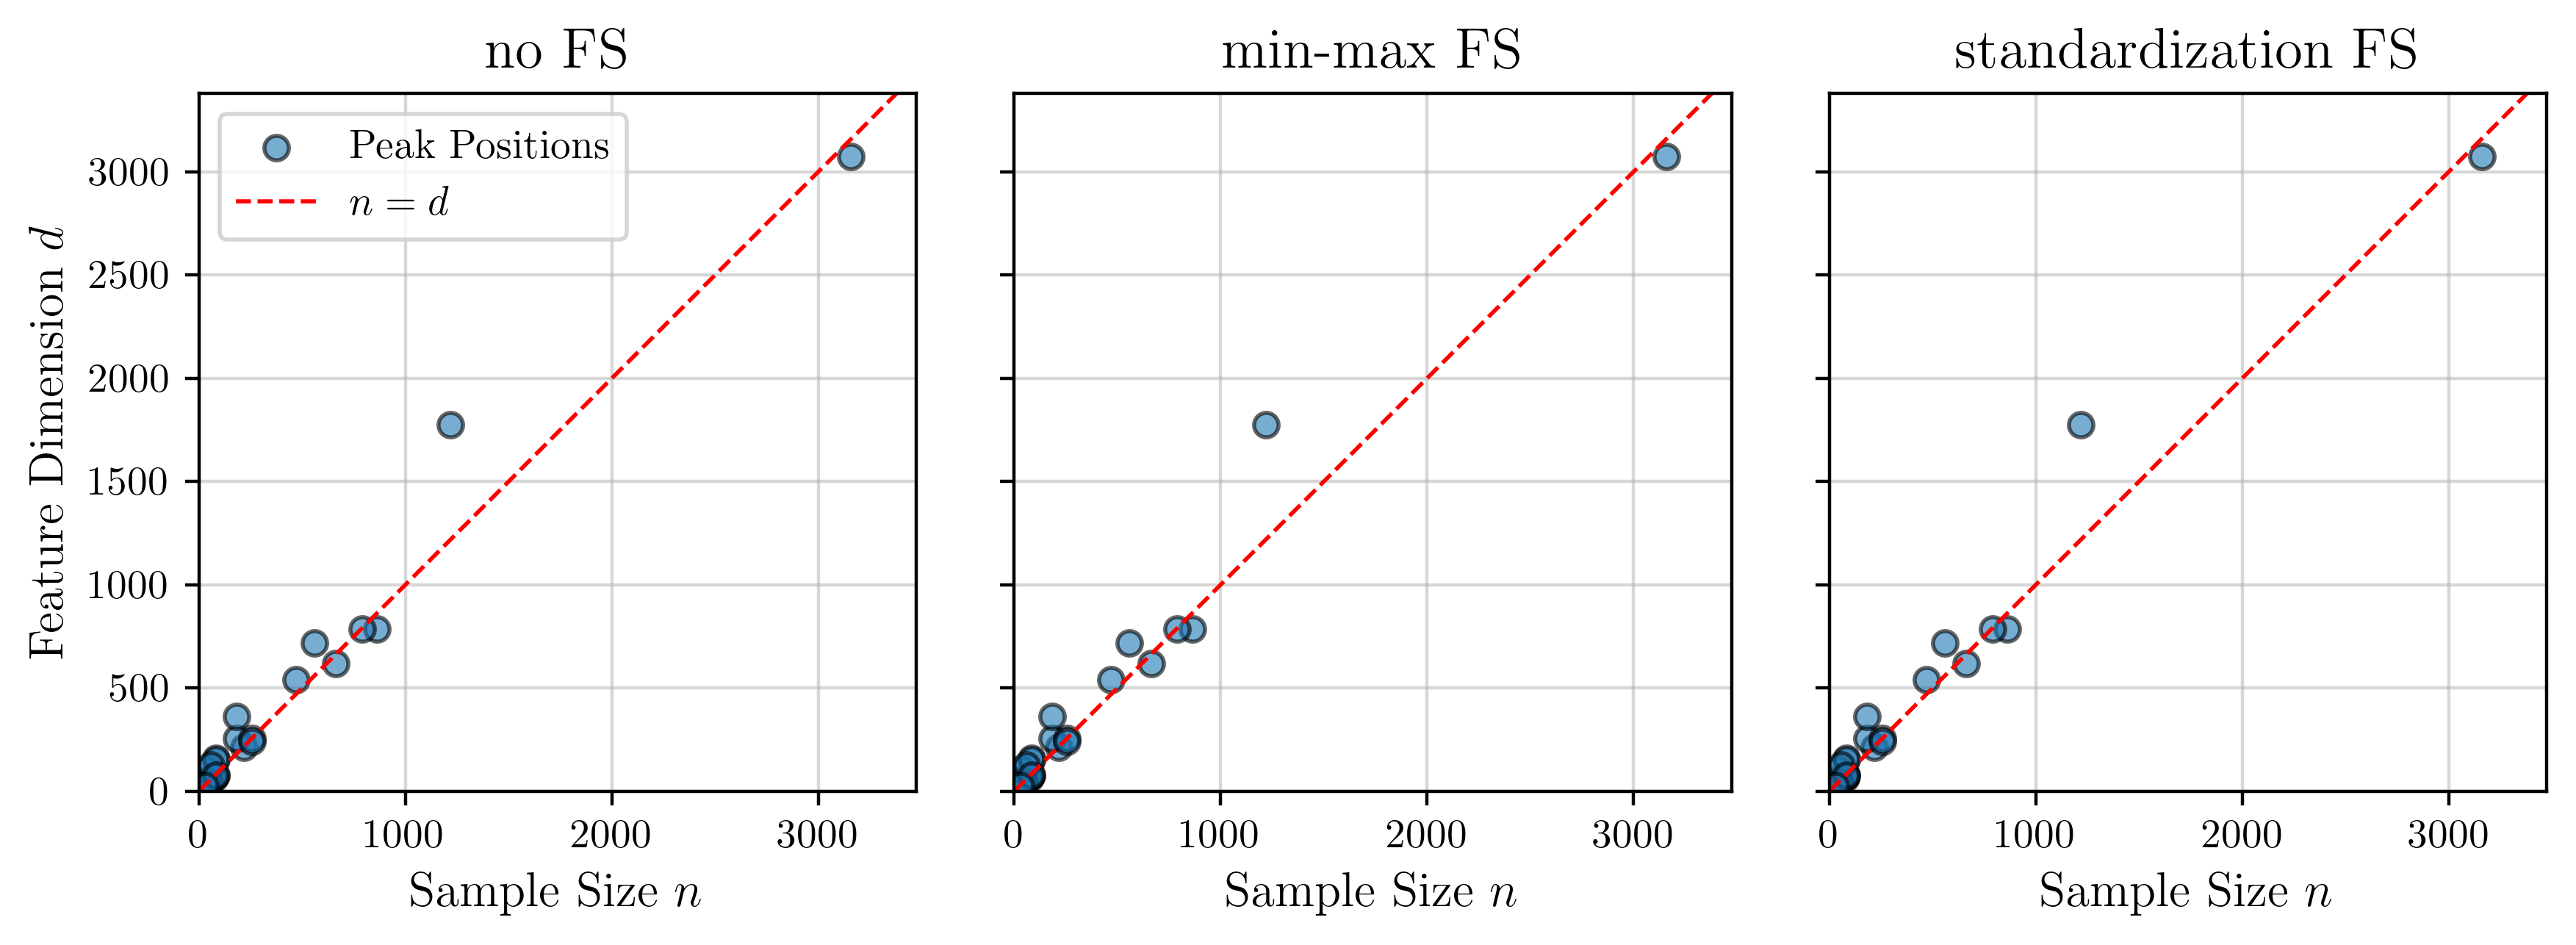

In [ ]:
LEARNER = 12

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, dpi=400)  
titles = ["no FS", "min-max FS", "standardization FS"]

for idx, (matrix, dataset, ax, title) in enumerate(zip(
    [conv_i_matrix_nofs, conv_i_matrix_minmaxfs, conv_i_matrix_standardfs], 
    [dataset_nofs, dataset_minmaxfs, dataset_standardfs], axes, titles)):

    n_values = []
    d_values = []

    for data_idx in range(conv_i_matrix_nofs.shape[1]):
        if np.isnan(matrix[LEARNER, data_idx]):  
            continue

        peak_position = matrix[LEARNER, data_idx] 
        ideal_peak = feature_num_CC18_remove_redundancy[data_idx] 
        n_values.append(peak_position)
        d_values.append(ideal_peak)

    ax.scatter(n_values, d_values, alpha=0.6, edgecolors='k', label='Peak Positions')

    max_value = max(max(d_values), max(n_values)) * 1.1
    d_range = np.linspace(0, max_value, 100)
    ax.plot(d_range, d_range, 'r--', linewidth=1, label='$n = d$')

    ax.set_xlabel('Sample Size $n$', fontsize=12)
    ax.set_ylabel('Feature Dimension $d$' if idx == 0 else "", fontsize=12)
    ax.set_xlim(0, max(n_values) * 1.1)
    ax.set_ylim(0, max(d_values) * 1.1)
    ax.set_title(title, fontsize=14)
    ax.set_axisbelow(True)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, alpha=0.5)

axes[0].legend()

plt.tight_layout()
plt.show()
